importing libraries

In [1]:
import pandas as pd
import numpy as np
import sklearn
import tensorflow as tf
import logging
import time

In [2]:
import cassandra

In [4]:
import face_recognition

retrive the data from cassandra DB (may it was hibernated , if it is happened run the next cell... )

In [5]:
from cassandra.cluster import Cluster
from cassandra.auth import PlainTextAuthProvider

cloud_config= {
  'secure_connect_bundle': 'secure-connect-sample.zip'
}
auth_provider = PlainTextAuthProvider('WZnAUhYtZZCrGJbMRAsWaNUO', 'AoGWhtEbRLx89e+QwIa0qUd,y_AAdyl_8KkJv1Uguc+etLhArJgZg+3_tSkHSdD--s2PMAPoZna7ALlHC2pH_7aI+P9ddSe375qFbKjvFqhabfHW5tY3H5g8wz_tL76A')
cluster = Cluster(cloud=cloud_config, auth_provider=auth_provider)
session = cluster.connect()

row = session.execute("select release_version from system.local").one()
if row:
  print(row[0])
else:
  print("An error occurred.")

query = "SELECT * FROM csv.bmidataset"
df = pd.DataFrame(list(session.execute(query)))

4.0.0.6816


reading the csv file using pandas 

In [62]:
df=pd.read_csv("bmi data set.csv")

creating the log file 

In [6]:
logging.basicConfig(filename='bmi.log', level=logging.INFO, format='%(asctime)s:%(levelname)s:%(message)s')

In [7]:
from pathlib import Path as p

In [8]:
#to identify the image name and iterate starts from 0

def get_index_of_digit(string):
    import re
    match = re.search("\d", p(string).stem)
    return match.start(0)

defining the data folder

In [9]:
data_folder = "sample_faces"

In [10]:
from glob import glob
all_files = glob(data_folder+"/*")

all_jpgs = sorted([img for img in all_files if ".jpg" in img or ".jpeg" in img or "JPG" or "png" or "PNG" in img])
logging.info("Total %d photos", len(all_jpgs))
print("Total {} photos ".format(len(all_jpgs)))

Total 257 photos 


In [11]:
id_dir = [(p(images).stem[:(get_index_of_digit(p(images).stem))],images) for  images in all_jpgs ]

In [12]:
image_df = pd.DataFrame(id_dir,columns=['UID','path'])

In [13]:
data_df = image_df.merge(df)

In [14]:
data_df

,UID,path,id,name,height,weight,BMI
0,akshay,sample_faces\akshay1.jpeg,1,akshay kumar,1.78,80,25.2493372
1,akshay,sample_faces\akshay10.jpg,1,akshay kumar,1.78,80,25.2493372
2,akshay,sample_faces\akshay11.jpg,1,akshay kumar,1.78,80,25.2493372
3,akshay,sample_faces\akshay12.jpg,1,akshay kumar,1.78,80,25.2493372
4,akshay,sample_faces\akshay13.jpg,1,akshay kumar,1.78,80,25.2493372
...,...,...,...,...,...,...,...
224,vikky,sample_faces\vikky5.jpg,8,vicky kaushal,1.83,80,23.88844098
225,vikky,sample_faces\vikky6.jpg,8,vicky kaushal,1.83,80,23.88844098
226,vikky,sample_faces\vikky7.jpg,8,vicky kaushal,1.83,80,23.88844098
227,vikky,sample_faces\vikky8.jpg,8,vicky kaushal,1.83,80,23.88844098


defining the function for face data extraction

In [15]:
def my_face_encoding(image_path):
    print(image_path)
    logging.info("Getting face encoding for image %s", image_path)
    picture_of_me = face_recognition.load_image_file(image_path)
    my_face_encoding = face_recognition.face_encodings(picture_of_me)
    if not my_face_encoding:
        print("no face found !!!")
        logging.warning("No face found in image %s", image_path)
        return np.zeros(128).tolist()
    return my_face_encoding[0].tolist()

In [16]:
tot_faces = []

iteration and appending

In [17]:
for images in data_df.path:
    face_enc = my_face_encoding(images)
    tot_faces.append(face_enc)

sample_faces\akshay1.jpeg
sample_faces\akshay10.jpg
sample_faces\akshay11.jpg
sample_faces\akshay12.jpg
sample_faces\akshay13.jpg
sample_faces\akshay14.jpg
sample_faces\akshay15.jpg
sample_faces\akshay16.jpg
sample_faces\akshay17.jpg
sample_faces\akshay18.jpg
sample_faces\akshay19.jpg
sample_faces\akshay2.jpeg
no face found !!!
sample_faces\akshay20.jpg
sample_faces\akshay3.jpg
sample_faces\akshay4.jpg
sample_faces\akshay5.jpg
sample_faces\akshay6.jpg
sample_faces\akshay7.jpg
sample_faces\akshay8.jpg
sample_faces\akshay9.jpg
sample_faces\amir1.jpg
sample_faces\amir10.jpg
sample_faces\amir11.jpg
sample_faces\amir12.jpg
sample_faces\amir13.jpg
sample_faces\amir14.jpeg
sample_faces\amir15.jpg
sample_faces\amir2.jpg
sample_faces\amir3.jpg
sample_faces\amir4.jpeg
no face found !!!
sample_faces\amir5.jpg
sample_faces\amir6.PNG
sample_faces\amir7.jpeg
sample_faces\amir8.jpg
sample_faces\amir9.jpg
sample_faces\anupam2.jpg
sample_faces\anupam3.jpg
sample_faces\anupam4.jpg
sample_faces\anupam5.j

In [18]:
X = np.array(tot_faces)

In [19]:
y_height = data_df.height.values
y_weight = data_df.weight.values

splitting the dataset

In [20]:
from sklearn.model_selection import train_test_split

In [21]:
X_train, X_test, y_height_train, y_height_test, y_weight_train, y_weight_test = train_test_split(X, y_height,y_weight, random_state=1)

Converting the data Type into float

In [22]:
y_height_train=y_height_train.astype(float)
y_height_test=y_height_test.astype(float)
y_weight_train=y_weight_train.astype(float)
y_weight_test=y_weight_test.astype(float)

getting the shape of the Training data

In [23]:
print(X_train.shape)

(171, 128)


Train the model using CNN

Developing height model

In [24]:
# Define the model architecture
model_height = tf.keras.Sequential([
    tf.keras.layers.Reshape((X_train.shape[1], 1), input_shape=(X_train.shape[1],)),
    tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(filters=128, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dense(units=1, activation='relu')
    ])
model_height.compile(loss='mse', optimizer='adam',metrics=['mae'])

# Fit the model to the training data
model_height.fit(X_train, np.log(y_height_train), epochs=13, batch_size=1)

# Evaluate the model on the test data
test_loss_height_cnn,test_height_accuracy = model_height.evaluate(X_test, np.log(y_height_test))

#logging 
logging.info("model height loss : %f, mae : %f", test_loss_height_cnn,test_height_accuracy)

#printing the metrics
print('loss of height:', test_loss_height_cnn)
print('mae of height:', test_height_accuracy)

#saving the model
model_height.save('height_model.h5')


Epoch 1/13
171/171 [==============================] - 5s 11ms/step - loss: 0.0235 - mae: 0.0862
Epoch 2/13
171/171 [==============================] - 2s 11ms/step - loss: 0.0020 - mae: 0.0321
Epoch 3/13
171/171 [==============================] - 2s 11ms/step - loss: 0.0015 - mae: 0.0273
Epoch 4/13
171/171 [==============================] - 2s 12ms/step - loss: 9.6012e-04 - mae: 0.0223
Epoch 5/13
171/171 [==============================] - 2s 10ms/step - loss: 6.8759e-04 - mae: 0.0209
Epoch 6/13
171/171 [==============================] - 2s 10ms/step - loss: 6.0829e-04 - mae: 0.0197
Epoch 7/13
171/171 [==============================] - 2s 10ms/step - loss: 5.7538e-04 - mae: 0.0194
Epoch 8/13
171/171 [==============================] - 2s 11ms/step - loss: 6.1515e-04 - mae: 0.0191
Epoch 9/13
171/171 [==============================] - 2s 12ms/step - loss: 4.7773e-04 - mae: 0.0171
Epoch 10/13
171/171 [==============================] - 2s 10ms/step - loss: 5.8292e-04 - mae: 0.0195
Epoch 11/13

Developing weight model

In [25]:
model_weight = tf.keras.Sequential([
    tf.keras.layers.Reshape((X_train.shape[1], 1), input_shape=(X_train.shape[1],)),
    tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(filters=128, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1, activation='relu')
])

model_weight.compile(loss='mse', optimizer='adam', metrics=['mae'])

model_weight.fit(X_train, np.log(y_weight_train), epochs=13, batch_size=1)

test_loss_weight_cnn, test_weight_accuracy = model_weight.evaluate(X_test, np.log(y_weight_test))

logging.info("model weight loss : %f, mae : %f", test_loss_weight_cnn,test_weight_accuracy)
print('loss of weight:', test_loss_weight_cnn)
print('mae of weight:', test_weight_accuracy)

#saving the model
model_weight.save('weight_model.h5')


Epoch 1/13
171/171 [==============================] - 5s 10ms/step - loss: 0.9494 - mae: 0.4875
Epoch 2/13
171/171 [==============================] - 2s 9ms/step - loss: 0.1085 - mae: 0.2428
Epoch 3/13
171/171 [==============================] - 2s 11ms/step - loss: 0.0793 - mae: 0.2039
Epoch 4/13
171/171 [==============================] - 2s 9ms/step - loss: 0.0602 - mae: 0.1807
Epoch 5/13
171/171 [==============================] - 2s 9ms/step - loss: 0.0503 - mae: 0.1623
Epoch 6/13
171/171 [==============================] - 2s 10ms/step - loss: 0.0335 - mae: 0.1321
Epoch 7/13
171/171 [==============================] - 2s 9ms/step - loss: 0.0338 - mae: 0.1398
Epoch 8/13
171/171 [==============================] - 2s 9ms/step - loss: 0.0292 - mae: 0.1289
Epoch 9/13
171/171 [==============================] - 2s 10ms/step - loss: 0.0268 - mae: 0.1277
Epoch 10/13
171/171 [==============================] - 2s 9ms/step - loss: 0.0192 - mae: 0.1065
Epoch 11/13
171/171 [========================

In [26]:
#load the models

height_model = tf.keras.models.load_model('height_model.h5')
weight_model = tf.keras.models.load_model('weight_model.h5')


def predict_height_weight_BMI(input_img,height_model,weight_model):
    logging.info("Predicting height, weight, and BMI for image %s", input_img)
    start_time = time.time()
    test_array = np.expand_dims(np.array(my_face_encoding(input_img)),axis=0)
    height = np.ndarray.item(np.exp(height_model.predict(test_array)))
    weight = np.ndarray.item(np.exp(weight_model.predict(test_array)))
    bmi = weight / (height)**2
    end_time = time.time()
    runtime = end_time - start_time
    logging.info("Predicted height: %f, weight: %f, BMI: %f, runtime : %s", height, weight, bmi, runtime)
    return {'height':height,"weight":weight,"bmi":bmi,'runtime':runtime}


for code level deployment

In [27]:
from IPython.display import Image

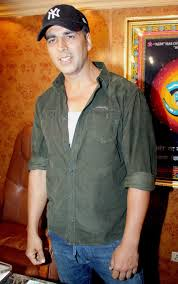

In [28]:
input_img = 'sample_faces/akshay1.jpeg'
Image(input_img)

In [29]:
predict_height_weight_BMI(input_img,height_model,weight_model)

sample_faces/akshay1.jpeg
1/1 [==============================] - 0s 393ms/step


{'height': 1.7140802145004272,
 'weight': 74.26966094970703,
 'bmi': 25.27837530517264,
 'runtime': 2.7309978008270264}

creating GUI using tkinter ( use "q" to capture image )

In [31]:
import tkinter as tk
from tkinter import filedialog
from PIL import ImageTk, Image
import cv2


# Load the height, weight, and BMI models
height_model = tf.keras.models.load_model('height_model.h5')
weight_model = tf.keras.models.load_model('weight_model.h5')


# Define the function to predict height, weight, and BMI
def predict_height_weight_BMI(input_img,height_model,weight_model):
    logging.info("Predicting height, weight, and BMI for image %s", input_img)
    test_array = np.expand_dims(np.array(my_face_encoding(input_img)),axis=0)
    height = np.ndarray.item(np.exp(height_model.predict(test_array)))
    weight = np.ndarray.item(np.exp(weight_model.predict(test_array)))
    bmi = weight / (height)**2
    logging.info("Predicted height: %f, weight: %f, BMI: %f", height, weight, bmi)
    return {'height':height,"weight":weight,"bmi":bmi}

# Define a function to get the file path of the selected image
def browse_file():
    global photo # Add this line to access the global variable
    file_path = filedialog.askopenfilename()
    if file_path:
        # Open the selected image and display it in the UI
        image = Image.open(file_path)
        image = image.resize((300, 300), Image.ANTIALIAS)
        photo = ImageTk.PhotoImage(image)
        canvas.itemconfigure(image_id, image=photo)
        canvas.image = photo

        # Call the predict_height_weight_BMI() function and display the results in the UI
        result = predict_height_weight_BMI(file_path, height_model, weight_model)
        result_label.config(text=f"Height: {result['height']:.2f}\nWeight: {result['weight']:.2f}\nBMI: {result['bmi']:.2f}")

def tocapture_image():
    global photo # Add this line to access the global variable
    cap = cv2.VideoCapture(0)
    cap.set(3,640) # set Width
    cap.set(4,480) # set Height
    while(True):
        ret, frame = cap.read()
        if ret:
            cv2.imshow('frame', frame)
            if cv2.waitKey(1) & 0xFF == ord('q'):
                # Save the captured image and display it in the UI
                cv2.imwrite('captured_image.jpg', frame)
                image = Image.open('captured_image.jpg')
                image = image.resize((300, 300), Image.ANTIALIAS)
                photo = ImageTk.PhotoImage(image)
                canvas.itemconfigure(image_id, image=photo)
                canvas.image = photo

                # Call the predict_height_weight_BMI() function and display the results in the UI
                result = predict_height_weight_BMI('captured_image.jpg', height_model, weight_model)
                result_label.config(text=f"Height: {result['height']:.2f}\nWeight: {result['weight']:.2f}\nBMI: {result['bmi']:.2f}")
                break
    cap.release()
    cv2.destroyAllWindows()


# Define a function to clear the selected image and results
def toclear_display():
    global photo # Add this line to access the global variable
    canvas.delete(image_id)
    result_label.config(text="")
    photo = None # Set the global variable to None to allow the PhotoImage object to be garbage collected

# Create the main window
root = tk.Tk()
root.title("Predict Height, Weight, and BMI")

# Create the canvas to display the image
canvas = tk.Canvas(root, width=300, height=300)
canvas.pack()

# Create a label to display the results
result_label = tk.Label(root, font=("Arial", 14),bg='yellow')
result_label.pack(pady=10)


# Create a frame for the buttons
button_frame = tk.Frame(root)
button_frame.pack(pady=10)

# Create a button to browse for an image
browse_button = tk.Button(button_frame, text="Browse", command=browse_file ,bg='skyblue')
browse_button.pack(side=tk.LEFT, padx=10)

# Create a button to capture image from the camera
capture_button = tk.Button(button_frame, text="Capture", command=tocapture_image,bg='pink')
capture_button.pack(side=tk.LEFT, padx=10)

# Create a button to clear the displayed image and results
clear_button = tk.Button(button_frame, text="Clear", command=toclear_display)
clear_button.pack(side=tk.RIGHT, padx=10)

# Initialize the image_id variable
image_id = canvas.create_image((0, 0), anchor='nw')



# Start the main loop
root.mainloop()



C:\Users\ROCKRAM\AppData\Local\Temp\ipykernel_3180\2701433283.py:29: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  image = image.resize((300, 300), Image.ANTIALIAS)


C:/Users/ROCKRAM/Desktop/project1/sample_faces/akshay5.jpg
1/1 [==============================] - 1s 1s/step


C:\Users\ROCKRAM\AppData\Local\Temp\ipykernel_3180\2701433283.py:51: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  image = image.resize((300, 300), Image.ANTIALIAS)


captured_image.jpg
1/1 [==============================] - 0s 400ms/step
captured_image.jpg
no face found !!!
1/1 [==============================] - 0s 252ms/step
captured_image.jpg
1/1 [==============================] - 0s 210ms/step
